# THE BATTLE OF NEIGHBORHOODS

# Introduction:

New York City's is busiest city in the world with highly populated diverse ethnics. With this project we want to list out major bakers through out and its neighborhood.
We will list and visualize all well rated bakers in New York.

# Data:

For this project we need the following data:
1. New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
2. Bakers in each neighborhood of new york city using FourSquare API.
3. GeoSpace data

## Questions that will be answers at the end of this project :

### 1. What are best location in New York City for Bakers?
### 2. Which areas have potential Bakers?
### 3. Which all areas lack Bakers?
### 4. Which is the best place to stay if you Bakers?

# Methodology:

Lets Start by importing the required Libraries.

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
!pip install geocoder
import geocoder
import os
!pip install folium
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
!pip install geopy
import geopy

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

## Package Plan ##

  environment location: D:\anaconda3

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.4                |   py37hc8dfbb8_2         3.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following packages will be UPDATED:

  conda                                4.8.3-py37hc8dfbb8_1 --> 4.8.4-py37hc8dfbb8_2




conda-4.8.4          | 3.1 MB    |            |   0% 
conda-4.8.4          | 3.1 MB    |            |   1% 
conda-4.8.4          | 3.1 MB    | 2          |   2% 
conda-4.8.4          | 3.1 MB    | 3          |   4% 
conda-4.8.4          | 3.1 MB    | 4          |   4% 
conda-4.8.4          | 3.1 MB    | 8          |   8% 
conda-4.8.4          | 3.1 MB    | 9          | 

Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [15]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [16]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'ZIVVO4TOBD45GSAAPZEAJUENFKZXZHADM1TTKOKRQVIJPC1M' # your Foursquare ID
    CLIENT_SECRET = 'KIFUSOPLJF2XG44URPKG2AACZ5XTJXAK20SHSEMHD54MCJ24' # your Foursquare Secret
    VERSION = '20200401' # Foursquare API version
  

    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [165]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'JMNCQD3QWMYC5JMN2XU1U2FF1QH5XHZTZDIDZM5LIFXKVLN0' # your Foursquare ID
    CLIENT_SECRET = 'JNW5LMTPV1DAE3UWOYPPN3QNJPOKXJHKCWROVHWWPWBIYBWE' # your Foursquare Secret
    VERSION = '20200401' 
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    print(results)
  
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df 

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [18]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [19]:
new_york_data=get_new_york_data()

In [20]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:
new_york_data.shape

(306, 4)

### The above result shows that there are 306 different Neighborhoods in New York.

Now let create a BAR PLOT to show different Neighborhoods in New York.

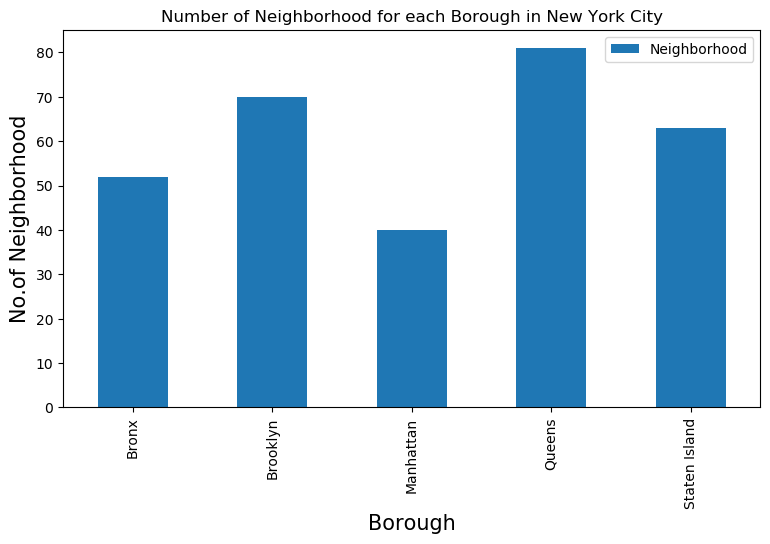

In [38]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### From the above Bar Plot, we can see that Queens has highest number of neighborhoods.

Next we will collect Bakery information for each Neighborhood.

In [40]:
# prepare neighborhood list that contains Bakery
column_names=['Borough', 'Neighborhood', 'ID','Name']
bakery_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    bakery=venues[venues['Category']=='Bakery']   
    print('(',count,'/',len(new_york_data),')','Bakery in '+Neighborhood+', '+Borough+':'+str(len(bakery)))
    for bakery_detail in bakery.values.tolist():
        id, name , category=bakery_detail
        bakery_ny = bakery_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Bakery in Wakefield, Bronx:2
( 2 / 306 ) Bakery in Co-op City, Bronx:2
( 3 / 306 ) Bakery in Eastchester, Bronx:1
( 4 / 306 ) Bakery in Fieldston, Bronx:1
( 5 / 306 ) Bakery in Riverdale, Bronx:0
( 6 / 306 ) Bakery in Kingsbridge, Bronx:2
( 7 / 306 ) Bakery in Marble Hill, Manhattan:2
( 8 / 306 ) Bakery in Woodlawn, Bronx:2
( 9 / 306 ) Bakery in Norwood, Bronx:0
( 10 / 306 ) Bakery in Williamsbridge, Bronx:3
( 11 / 306 ) Bakery in Baychester, Bronx:2
( 12 / 306 ) Bakery in Pelham Parkway, Bronx:3
( 13 / 306 ) Bakery in City Island, Bronx:0
( 14 / 306 ) Bakery in Bedford Park, Bronx:0
( 15 / 306 ) Bakery in University Heights, Bronx:1
( 16 / 306 ) Bakery in Morris Heights, Bronx:0
( 17 / 306 ) Bakery in Fordham, Bronx:2
( 18 / 306 ) Bakery in East Tremont, Bronx:0
( 19 / 306 ) Bakery in West Farms, Bronx:0
( 20 / 306 ) Bakery in High  Bridge, Bronx:0
( 21 / 306 ) Bakery in Melrose, Bronx:1
( 22 / 306 ) Bakery in Mott Haven, Bronx:0
( 23 / 306 ) Bakery in Port Morris, Bronx:0

Now that we have got all the bakery in new york city , we will analyze it.

In [42]:
bakery_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4cd3edd25366548131a129ed,E&L Bakery
1,Bronx,Wakefield,4f6e2346e4b03b575cdceb3e,Dee-Lectable Pleasure Cakes
2,Bronx,Co-op City,4a720b8ef964a52036da1fe3,Panera Bread
3,Bronx,Co-op City,4c433c8fce54e21ef8c50d1a,The Cookie Factory
4,Bronx,Eastchester,564d19cd498eef10e4500403,Panera Bread


In [25]:
bakery_ny.shape

(334, 4)

### From the above result, we see that there are 334 bakers across New York City.

Now let create a BAR PLOT to show Number of bakers for each Borough in New York City.

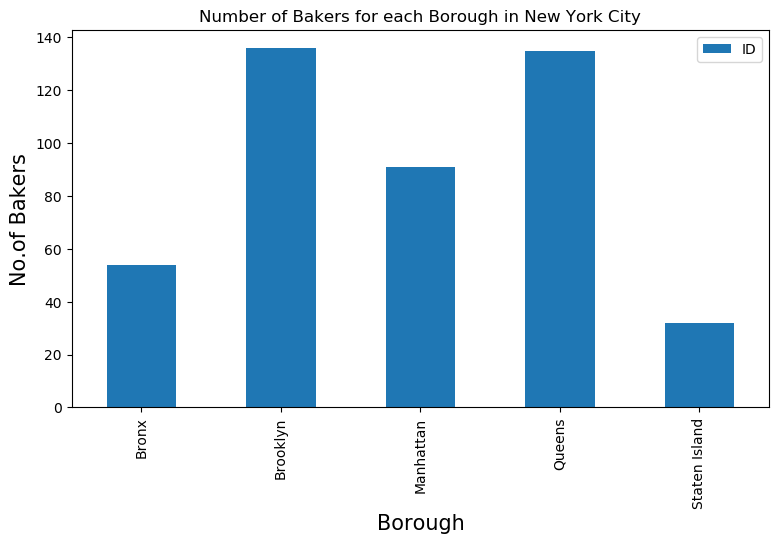

In [43]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Bakers for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Bakers', fontsize=15)
#giving a bar plot
bakery_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### From the above Bar Plot, we can see that Brooklyn has highest number of Bakers.

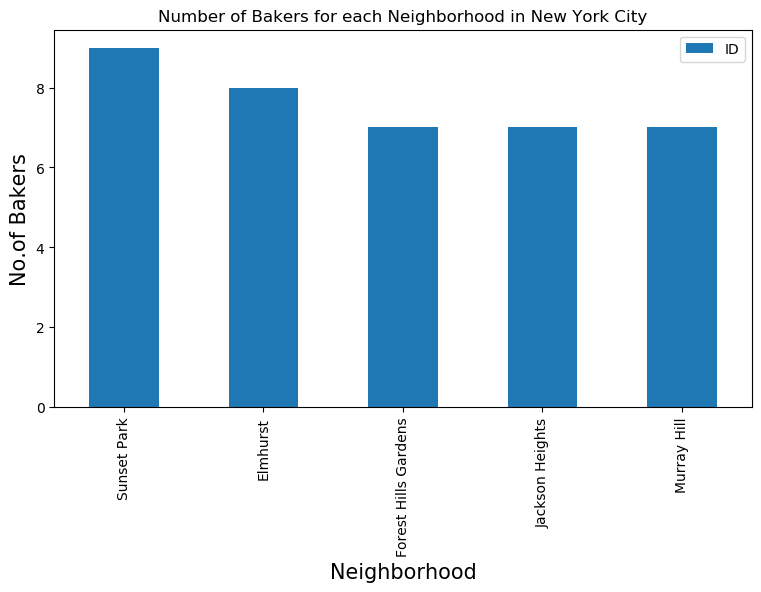

In [44]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Bakers for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Bakers', fontsize=15)
#giving a bar plot
bakery_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [125]:
bakery_ny[bakery_ny['Neighborhood']=='Sunset Park']


,Borough,Neighborhood,ID,Name
58,Brooklyn,Sunset Park,4ad24975f964a520b4e020e3,La Gran Via Bakery
59,Brooklyn,Sunset Park,4b8d36cbf964a520bbed32e3,Don Paco Lopez Panaderia
60,Brooklyn,Sunset Park,4bcbb36668f976b0fcac6183,La Flor Bakery
61,Brooklyn,Sunset Park,4cb83ab24c60a0930e1737ca,Generoso's Bakery
62,Brooklyn,Sunset Park,4bc2ad2474a9a59300a9d3f6,Las Rosas Bakery
63,Brooklyn,Sunset Park,4bb15325f964a520608c3ce3,Savoy Bakery
64,Brooklyn,Sunset Park,4d0d39c0257d6dcbc1ec9a67,Xin Fa Bakery Inc.
65,Brooklyn,Sunset Park,5dc72748391f9900073b56cb,Paris Baguette
66,Brooklyn,Sunset Park,4d5cec456f6d6ea828ff69ec,Angel's Bakery


In [157]:
bakery_ny.shape

(178, 4)

In [158]:
bakery_ny.drop_duplicates( subset ="Name", keep = False, inplace = True)

### We can see that, Sunset Park in Brooklyn has the highest number of Bakers with a total count of 9.

Now we will get the ranking of each bakers for further analysis.

In [155]:
bakery_ny.shape

(178, 4)

In [167]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
bakery_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in bakery_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
       
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(bakery_ny),')','processed')
    bakery_stats_ny = bakery_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f36de7386af5269450be560'}, 'response': {}}


KeyError: 'venue'

In [161]:
bakery_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips


In [ ]:
bakery_stats_ny.shape

Now that we got data for all bakers Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required.

In [35]:
bakery_stats_ny.to_csv('bakery_stats_ny.csv', index=False)

Lets verify the data from saved csv file.

In [168]:
bakery_stats_ny_csv=pd.read_csv('bakery_stats_ny.csv')

In [169]:
bakery_stats_ny_csv.shape

(50, 7)

In [170]:
bakery_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,4cd3edd25366548131a129ed,E&L Bakery,7,6.5,4
1,Bronx,Wakefield,0,0,0,0.0,0
2,Bronx,Co-op City,4a720b8ef964a52036da1fe3,Panera Bread,118,8.3,38
3,Bronx,Co-op City,4c433c8fce54e21ef8c50d1a,The Cookie Factory,7,8.1,4
4,Bronx,Co-op City,0,0,0,0.0,0


In [172]:
bakery_stats_ny_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     int64  
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 2.9+ KB


The Data type of 'Likes' and  'Tips' are of type 'String'. we will convert them into type 'Float' for further analysis.

In [173]:
bakery_stats_ny_csv['Likes']=bakery_stats_ny_csv['Likes'].astype('float64')
bakery_stats_ny_csv['Tips']=bakery_stats_ny_csv['Tips'].astype('float64')

In [174]:
bakery_stats_ny_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


Now we will find the Indian restuarants with Maximum Likes, Maximum Ratings and Maximum Tips.

In [175]:
# bakers with maximum Likes
bakery_stats_ny_csv.iloc[indian_rest_stats_ny_csv['Likes'].idxmax()]

Borough                            Bronx
Neighborhood                  Co-op City
ID              4a720b8ef964a52036da1fe3
Name                        Panera Bread
Likes                                118
Rating                               8.3
Tips                                  38
Name: 2, dtype: object

In [176]:
# Bakers with maximum Rating
bakery_stats_ny_csv.iloc[indian_rest_stats_ny_csv['Rating'].idxmax()]

Borough                                  Bronx
Neighborhood                      Country Club
ID                    4c9205941adc370460a134d1
Name            Zeppieri & Sons Italian Bakery
Likes                                       32
Rating                                     9.2
Tips                                        11
Name: 28, dtype: object

In [30]:
# bakers with maximum Tips
bakery_stats_ny.iloc[bakery_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                837
Rating                               8.8
Tips                                 260
Name: 37, dtype: object

Next lets visualize neighborhood with maximum average rating of bakers.

In [177]:
ny_neighborhood_stats_csv=bakery_stats_ny_csv.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats_csv.columns=['Neighborhood','Average Rating']

In [178]:
ny_neighborhood_stats_csv.sort_values(['Average Rating'],ascending=False).head(10)


,Neighborhood,Average Rating
25,Woodlawn,8.800000
14,Melrose,8.800000
12,Longwood,8.800000
8,Fieldston,8.700000
0,Bay Ridge,8.500000
10,Hunts Point,8.100000
2,Belmont,8.083333
5,Country Club,8.033333
17,Pelham Bay,8.033333
23,Westchester Square,7.900000


### Above are the top neighborhoods with top average rating of Bakers.

Similarly we will find the average rating of bakers for each Borough.

In [179]:
ny_borough_stats=bakery_stats_ny_csv.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [180]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Brooklyn,8.500000
2,Manhattan,7.100000
0,Bronx,6.525532


TypeError: 'DataFrame' object is not callable

Lets Visualize it.

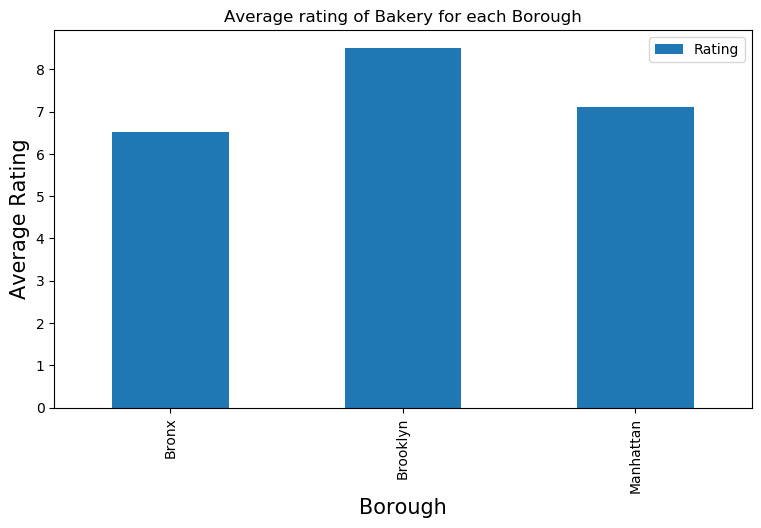

In [67]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Bakery for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny_csv.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map.

In [182]:
ny_neighborhood_stats_csv

,Neighborhood,Average Rating
0,Bay Ridge,8.500000
1,Baychester,7.550000
2,Belmont,8.083333
3,Co-op City,5.466667
4,Concourse,7.100000
5,Country Club,8.033333
6,Eastchester,4.300000
7,Edenwald,2.300000
8,Fieldston,8.700000
9,Fordham,7.700000


In [183]:
ny_neighborhood_stats1=ny_neighborhood_stats_csv[ny_neighborhood_stats_csv['Average Rating']>=7.0]

In [184]:
ny_neighborhood_stats1.shape

(16, 2)

We will join this dataset to original new york data to get lonitude and latitude.

In [185]:
ny_neighborhood_stats1=pd.merge(ny_neighborhood_stats1,new_york_data, on='Neighborhood')

In [186]:
ny_neighborhood_stats1=ny_neighborhood_stats1[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [187]:
ny_neighborhood_stats1

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bay Ridge,40.625801,-74.030621,8.500000
1,Bronx,Baychester,40.866858,-73.835798,7.550000
2,Bronx,Belmont,40.857277,-73.888452,8.083333
3,Bronx,Concourse,40.834284,-73.915589,7.100000
4,Bronx,Country Club,40.844246,-73.824099,8.033333
5,Bronx,Fieldston,40.895437,-73.905643,8.700000
6,Bronx,Fordham,40.860997,-73.896427,7.700000
7,Bronx,Hunts Point,40.809730,-73.883315,8.100000
8,Bronx,Kingsbridge,40.881687,-73.902818,7.550000
9,Bronx,Longwood,40.815099,-73.895788,8.800000


Finally, Let's show this data on a map.

In [189]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [190]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats1[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose.

In [191]:
ny_neighborhood_stats1['Label']=ny_neighborhood_stats1['Neighborhood']+', '+ny_neighborhood_stats1['Borough']+'('+ny_neighborhood_stats1['Average Rating'].map(str)+')'

In [192]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats1[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighborhoods.
Lets Visualize Boroughs based on average Rating.

In [193]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'D:\\downloads\\Borough_Boundaries.geojson'

map = ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

# Conclusion:

### So now we can answer the questions asked above in the Questions section of the notebook.
### From our anaysis the answers to the above questions are:

#### A1) Baybridge(Brooklyn), Woodlawn(Bronx), Melrose(Bronx),(Bronx) are some of the best neighborhoods for bakers.
#### A2) Brooklyn have potential bakers.
#### A3) Staten Island ranks last in number of bakers.
#### A4) Bronx is the best place to stay if you prefer bakery.